<a href="https://colab.research.google.com/github/pinellolab/DNA-Diffusion/blob/classifier-free-diff/Described_Classifier_Free_Enhancer_UNET_bitdiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DNA difussion
- 1x4x200 inputs

-  Curated dataset of 160,000 sequences, 10k per DHS NMF component, selected in such a way that each sequence is highly concentrated in a single component:

- UNET needs to be optimized to rectangular shape . It's currently accepting rectangular shapes (4,200) , but it can be probably improved for our model.(less memory and better performance). We need to check on the literature examples of SOTA sequence arquitectures. We may need a hybrid.
- This nootebook doens't have conditional inputs implemented(cell type, signal strenght , motifs)  
  - How to add this on the UNET? concact Embeddings on the UNET  blocks.
  - https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py  
- Change the bit diffusion sampling process  to expect conditional information 
  - Should be a simple task.(Adding the information on the model)
-How stable diffusion allows different levels of conditional "guidance"(how much the generation should care abount the text?). Are they adding factor to regulate the mask intensity?    

# Install Packages

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -Uqq ipdb
import ipdb


     |████████████████████████████████| 793 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 59.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


# UTILS

In [ ]:
import numpy as np


def one_hot_encode(seq, alphabet, max_seq_len):
    """One-hot encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(alphabet)))
    for i in range(seq_len):
        seq_array[i, alphabet.index(seq[i])] = 1
    return seq_array

In [ ]:
def encode(seq, alphabet):
    """Encode a sequence."""
    seq_len = len(seq)
    seq_array = np.zeros(len(alphabet))
    for i in range(seq_len):
        seq_array[alphabet.index(seq[i])] = 1
    
    return seq_array

In [ ]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import seaborn as sns
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm_notebook

import math
from pathlib import Path
from random import random
from functools import partial
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
from torch.special import expm1
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from torch.optim import Adam, SGD
from torchvision import transforms as T, utils

from PIL import Image
from tqdm.auto import tqdm

import torch
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast


import matplotlib.pyplot as plt

import seaborn as sns

import gc

# Downloading Dataset

In [ ]:
!curl -L -o train_all_classifier_WM20220916.csv.gz "https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2"
!gunzip train_all_classifier_WM20220916.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   146    0   146    0     0    557      0 --:--:-- --:--:-- --:--:--   555
100   340  100   340    0     0    729      0 --:--:-- --:--:-- --:--:--   729
100   534    0   534    0     0    622      0 --:--:-- --:--:-- --:--:--   622
100 21.3M  100 21.3M    0     0  12.7M      0  0:00:01  0:00:01 --:--:-- 50.1M
gzip: train_all_classifier_WM20220916.csv already exists; do you wish to overwrite (y or n)? ^C


# Loading Dataset and Processing


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("/content/train_all_classifier_WM20220916.csv", sep="\t")
df.head()

,Unnamed: 0,seqname,start,end,DHS_width,summit,total_signal,numsamples,numpeaks,C1,...,C10,C11,C12,C13,C14,C15,C16,raw_sequence,component,proportion
0,1241720,chr16,68843660,68843880,220,68843790,122.770678,61,61,0.101076,...,0.005301,0.016703,0.000000,0.000000,0.000000,0.000000,0.0,GAGGCATTGAAGCTGCTGCTGAGCCCGGGAGGTGAGAGGACGCATC...,0,0.767372
1,2251755,chr3,143634500,143634720,220,143634610,0.780678,1,1,0.000000,...,0.000000,0.000000,0.000000,0.008636,0.000000,0.000000,0.0,CTCTCCAACTTTTTCCCTGAGTATTGCCAGCACACTTTTAATCTCC...,12,0.869445
2,3136863,chr7,156928220,156928441,221,156928330,145.069295,32,32,0.000000,...,0.046526,0.002177,0.008559,0.000000,0.106442,0.000000,0.0,CTTCCTGATAAGATCTCAGGAGCTGGGCAAGTGGCTCAAGTATGTG...,13,0.585111
3,2234828,chr3,130738277,130738580,303,130738460,13.140313,10,10,0.000531,...,0.000000,0.000000,0.000000,0.000370,0.000000,0.043161,0.0,TGAGGAACATAAGCACATAAAATATAATCTAGAAGTTGGTGCTGAG...,14,0.961271
4,3060272,chr7,95784860,95785160,300,95785010,17.523798,7,7,0.000000,...,0.011486,0.000000,0.000000,0.000000,0.036866,0.000000,0.0,CCAGGTTCTGCCATTCACTTGGGGCCAGCATAAACAAGGGGGCAGG...,13,0.762448


- Compoenent is the celltype flag (In this dataset we have only 16 cell types)
- raw_sequence is the 200bp accessible sequence 
- seqname-start-end  Represents the peak coordinate
- summit is the DNA-se peak center (peak of accecibility)

In [ ]:
# This will be used to create the motifs analysis later on
# This will not be used in the model directly
save_fasta= open('fastq_train_component.fasta', 'w')
write_fasta_component = '\n'.join(df[['Unnamed: 0', 'raw_sequence', 'component']].apply(lambda x : f'>{x[0]}_component_{x[2]}\n{x[1]}', axis=1).values.tolist())
save_fasta.write(write_fasta_component)
save_fasta.close()

In [ ]:
len(df)

160000

In [ ]:
# 16 NMF cell types
df.component.nunique()

16

In [ ]:
cell_types = sorted(list(df.component.unique()))

In [ ]:
cell_types

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
# motifs = sorted(open("drive/MyDrive/unique_motifs.txt").read().splitlines())
# motifs[:5]

In [ ]:
dna_alphabet = ['A', 'C', 'T', 'G']
x_train_seq = np.array([one_hot_encode(x, dna_alphabet, 200) for x in tqdm_notebook(df['raw_sequence']) if 'N' not in x ])
x_train_seq = np.array([x.T.tolist()  for x in x_train_seq])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/160000 [00:00<?, ?it/s]

In [ ]:
#x_train_motif = np.array([encode(sorted(eval(x)), motifs) for x in tqdm_notebook(df['motifs'])])

In [ ]:
x_train_cell_type = F.one_hot(torch.from_numpy(df["component"].to_numpy()), len(cell_types))

In [ ]:
x_train_seq.shape, x_train_cell_type.shape

((160000, 4, 200), torch.Size([160000, 16]))

In [ ]:
nucleotides = ['A', 'C', 'T', 'G']


def show_seq(dataloader_seq):
    for i_image in dataloader_seq:
      for image in i_image:
        image = image.numpy().reshape(4,100)
        print (image)
        plt.rcParams["figure.figsize"] = (20,1)
        pd_seq = pd.DataFrame(image)
        pd_seq.index = nucleotides
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0) 
        plt.show()

class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, seqs, c, transform=None):
      'Initialization'
      self.seqs = seqs
      self.c = c
      self.transform = transform

    def __len__(self):
      'Denotes the total number of samples'
      return len(self.seqs)

    def __getitem__(self, index):
      'Generates one sample of data'
      # Select sample
      image = self.seqs[index]

      x = self.transform(image)

      y = self.c[index]
      
      return x, y
  

 

In [ ]:
tf = T.Compose([T.ToTensor()])
batch_size = 64
seq_dataset = SequenceDataset(seqs=x_train_seq, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(seq_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
for (x, y) in train_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 1, 4, 200])
torch.Size([64, 16])


### Train data examples

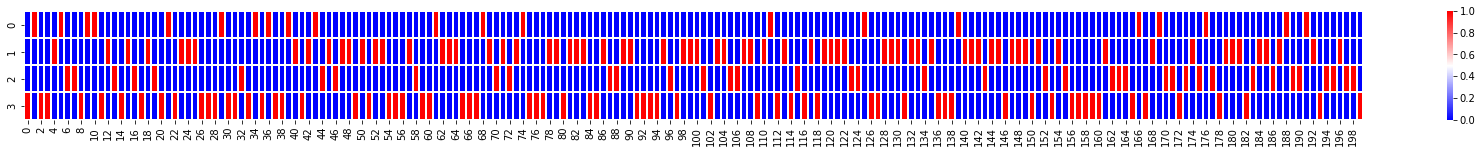

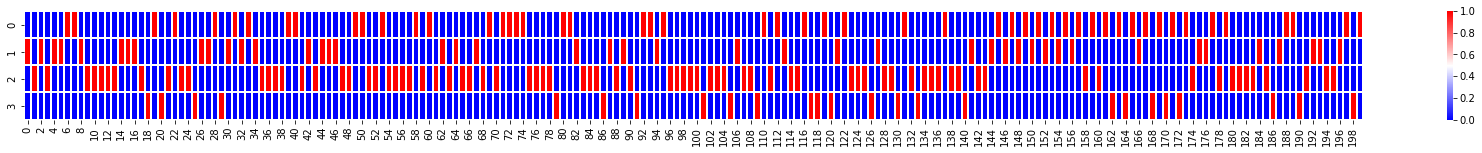

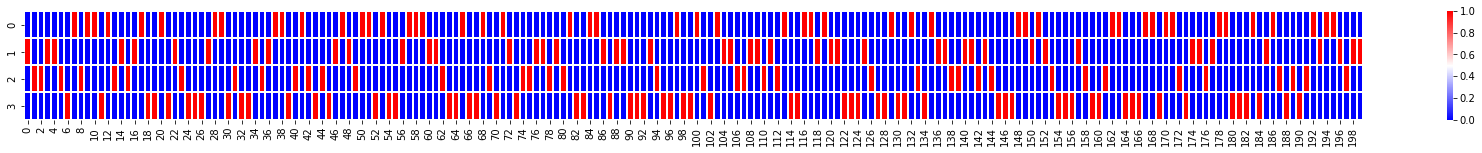

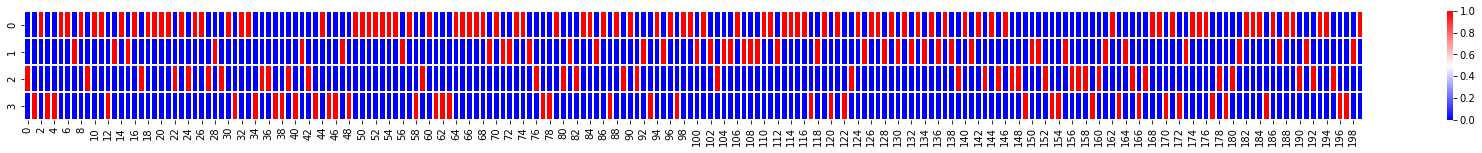

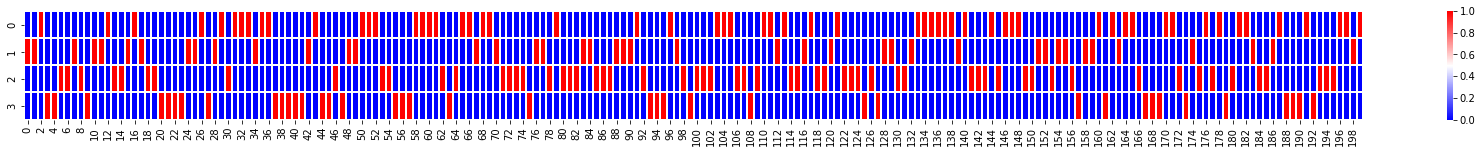

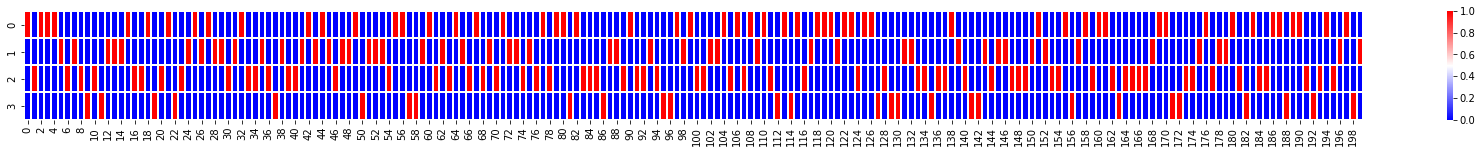

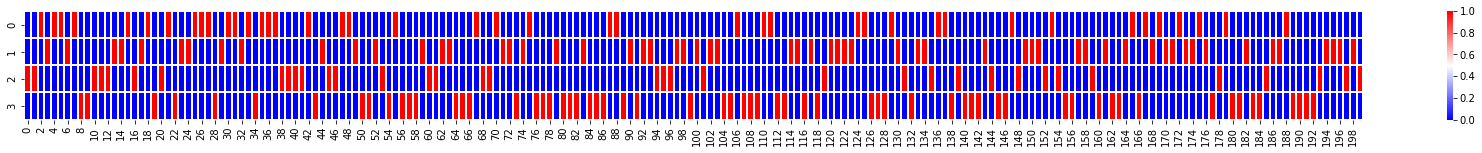

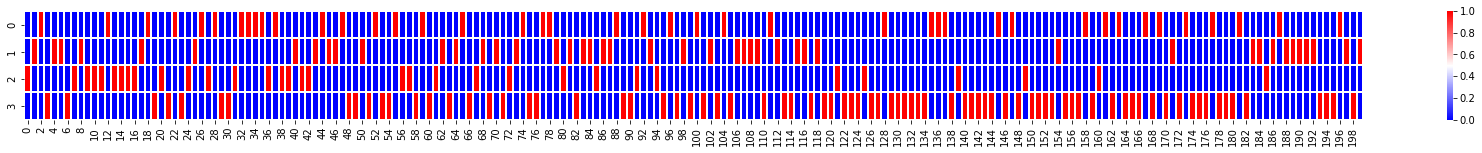

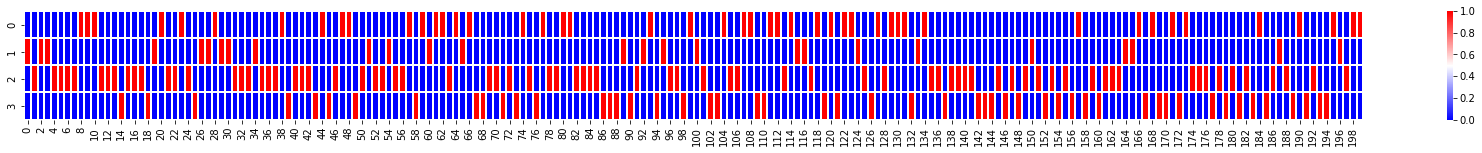

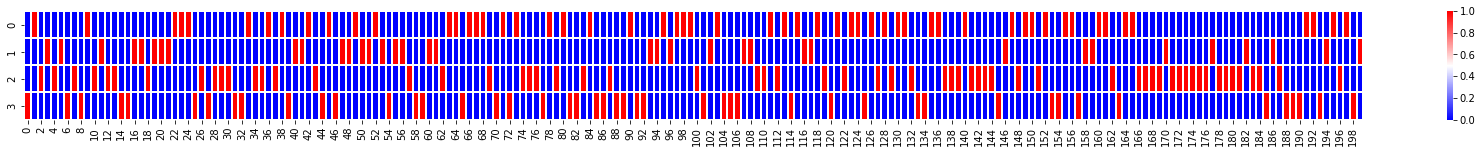

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

for x in x_train_seq[:10]:
  df = pd.DataFrame(x)
  plt.rcParams["figure.figsize"] = (30,2)
  sns.heatmap(df, cmap='bwr', linewidths=1)
  plt.show()

# Modified bit difussion code

Model was generating squared noise and expecting squared images.  
I adjusted it to expect the shape 4,200  

In [ ]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## CORE MODEL tasks


---



  - Is the bitnet really being helpful?  
  We already have the sequences converted to discrete space by using a hot encoding. But it seems that bitdiffusion is discretizing it again. Does it makes sense?
  - Should bitdiffusion be used only for continuous --> discrete cases?
  - Should we use 1 as the BITs representation? (We already tried it and Using BITS = 1 the models can't learn well ( BITS=1 loss =0.3 X BITS=8 loss= 0.014) 
  - How about having the diffusion add noise in the (-1,1) hot encoded sequence? We have tested it and were able to learn and overfit a small dataset (using a simple CNN2D). How does this simple model works if we use this UNET?
  

  
##Model exploration Taks
---
###Can we use stable diffusion instead bit difussion ?

 -Consider DNA embedding models to transition to use stable diffusion   
 -Training a VQ-VAE for DNA-sequences for stable diffusion  
    **Sammer can provide us his initial VQ-VAE**  

 -Working with multiple conditioning variables cell type + motifs presence (absence)  
 -Explore in-painting and outpainting of DNA sequences  
 
 **This noteebok can be used as the base for exploratory models**

In [ ]:
BITS = 8  


def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

def l2norm(t):
    return F.normalize(t, dim = -1)

# small helper modules


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d



class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# positional embeds

class LearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with learned sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = EmbedFC(time_emb_dim, dim_out * 2)

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim = None, groups = 8):
        super().__init__(dim=dim+class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)
      

  
    def forward(self, x, time_emb=None, c=None, mask=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])

        if mask:
          # mask classes so we can jointly train condtioned and unconditioned
          # masking with 1e-9 like we do in Transformers
          emb_c = emb_c.masked_fill(mask, 1e-9)

        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

def decimal_to_bits(x, bits = BITS):
    """ expects image tensor ranging from 0 to 1, outputs bit tensor ranging from -1 to 1 """
    device = x.device

    x = (x * 1).int().clamp(0, 1)  #x = (x * 255).int().clamp(0, 255)

    mask = 2 ** torch.arange(bits - 1, -1, -1, device = device)
    mask = rearrange(mask, 'd -> d 1 1')
    x = rearrange(x, 'b c h w -> b c 1 h w')

    bits = ((x & mask) != 0).float()
    bits = rearrange(bits, 'b c d h w -> b (c d) h w')
    bits = bits * 2 - 1
    return bits

def bits_to_decimal(x, bits = BITS):
    """ expects bits from -1 to 1, outputs image tensor from 0 to 1 """
    device = x.device

    x = (x > 0).int()
    mask = 2 ** torch.arange(bits - 1, -1, -1, device = device, dtype = torch.int32)

    mask = rearrange(mask, 'd -> d 1 1')
    #x = rearrange(x, 'b (c d) h w -> b c d h w', d = 8)
    x = rearrange(x, 'b (c d) h w -> b c d h w', d = BITS) #lucas

    dec = reduce(x * mask, 'b c d h w -> b c h w', 'sum')
    return (dec / 1).clamp(0., 1.)   # changed(dec / 255).clamp(0., 1.)

# bit diffusion class

def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

def beta_linear_log_snr(t):
    return -torch.log(expm1(1e-4 + 10 * (t ** 2)))

def alpha_cosine_log_snr(t, s: float = 0.0002, ds = .00025):
    return -log((torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** -2) - 1, eps = 1e-5) # not sure if this accounts for beta being clipped to 0.999 in discrete version


def log_snr_to_alpha_sigma(log_snr):
    return torch.sqrt(torch.sigmoid(log_snr)), torch.sqrt(torch.sigmoid(-log_snr))


def alpha_cosine_log_snr(t, ns=0.0002, ds=0.00025):
  # A scheduling function based on cosine function.
  return torch.cos(((t + ns) / (1 + ds)) * torch.pi / 2)**2




#UNET (current input is [4,200])


---


## UNET tasks


---



 - Refactoring the UNET bit diffusion code:  
 The UNET is not optimized to deal with 1,4,200  images. How can we make sure that we can optimize the kernels and U architecture? In the current moment, the internal kernels are U layers squared. Is it optimal?
    
 - Optimize the UNET architecture:  
 Is this architecture enough? Can we overfit a small dataset on this current architecture? Should we add more resnet_blocks? 

  -- We need to check on the literature examples of SOTA sequence arquitectures. We may need a hybrid.  (check this repo : https://github.com/kundajelab/bpnet
  )



In [ ]:
# each layer has a time embedding AND class conditioned embedding

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        bits = BITS,
        resnet_block_groups = 8,
        learned_sinusoidal_dim = 16,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        # determine dimensions

        channels *= bits #lucas
        self.channels = channels *2

        input_channels = channels * 2
        #input_channels =16

        
        init_dim = default(init_dim, dim)
        #self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3) # original TODO for zach: is there a difference?
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7,7), padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]


        in_out = list(zip(dims[:-1], dims[1:]))
        block_klass = partial(ResnetBlockClassConditioned, groups=resnet_block_groups,
                              num_classes=num_classes, class_embed_dim=class_embed_dim)

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )
        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)

        #self.final_conv = nn.Conv2d(dim, 1, 1) #lucas
        self.final_conv = nn.Conv2d(dim,8, 1)


    def forward(self, x, time, c, x_self_cond = None):
        #print(x.shape)
        #c = torch.zeros_like(c) # removing the conditioning LUCAS

        x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
        
        x = torch.cat((x_self_cond, x), dim=1)
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        
        # todo class mask

        h = []
        for i, (block1, block2, attn, downsample) in enumerate(self.downs):
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)

            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t, c)
        
        x = self.final_conv(x)
        #print(x.shape, 'final')
        return x

In [ ]:
class BitDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        use_ddim = False,
        noise_schedule = 'cosine',
        time_difference = 0.,
        bit_scale = 1.
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels

        self.image_size = image_size

        if noise_schedule == "linear":
            self.log_snr = beta_linear_log_snr
        elif noise_schedule == "cosine":
            self.log_snr = alpha_cosine_log_snr
        else:
            raise ValueError(f'invalid noise schedule {noise_schedule}')

        self.bit_scale = bit_scale

        self.timesteps = timesteps
        self.use_ddim = use_ddim

        # proposed in the paper, summed to time_next
        # as a way to fix a deficiency in self-conditioning and lower FID when the number of sampling timesteps is < 400

        self.time_difference = time_difference

    @property
    def device(self):
        return next(self.model.parameters()).device

    def get_sampling_timesteps(self, batch, *, device):
        times = torch.linspace(1., 0., self.timesteps + 1, device = device)
        times = repeat(times, 't -> b t', b = batch)
        times = torch.stack((times[:, :-1], times[:, 1:]), dim = 0)
        times = times.unbind(dim = -1)
        return times

    @torch.no_grad()
    def ddpm_sample(self, shape, time_difference=None, classes=None):
        batch, device = shape[0], self.device

        time_difference = default(time_difference, self.time_difference)

        time_pairs = self.get_sampling_timesteps(batch, device = device)

        img = torch.randn(shape, device=device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step', total = self.timesteps):

            # add the time delay

            time_next = (time_next - self.time_difference).clamp(min = 0.)

            noise_cond = self.log_snr(time)

            # get predicted x0

            x_start = self.model(img, noise_cond, classes, x_start)

            # clip x0

            x_start.clamp_(-self.bit_scale, self.bit_scale)

            # get log(snr)

            log_snr = self.log_snr(time)
            log_snr_next = self.log_snr(time_next)
            log_snr, log_snr_next = map(partial(right_pad_dims_to, img), (log_snr, log_snr_next))

            # get alpha sigma of time and next time

            alpha, sigma = log_snr_to_alpha_sigma(log_snr)
            alpha_next, sigma_next = log_snr_to_alpha_sigma(log_snr_next)

            # derive posterior mean and variance

            c = -expm1(log_snr - log_snr_next)

            mean = alpha_next * (img * (1 - c) / alpha + c * x_start)
            variance = (sigma_next ** 2) * c
            log_variance = log(variance)

            # get noise

            noise = torch.where(
                rearrange(time_next > 0, 'b -> b 1 1 1'),
                torch.randn_like(img),
                torch.zeros_like(img)
            )

            img = mean + (0.5 * log_variance).exp() * noise

        return bits_to_decimal(img)

    @torch.no_grad()
    def ddim_sample(self, shape, classes, time_difference = None):
        batch, device = shape[0], self.device

        time_difference = default(time_difference, self.time_difference)

        time_pairs = self.get_sampling_timesteps(batch, device = device)
        img = torch.randn(shape, device = device)

        x_start = None

        for times, times_next in tqdm(time_pairs, desc = 'sampling loop time step'):

            # get times and noise levels

            log_snr = self.log_snr(times)
            log_snr_next = self.log_snr(times_next)

            padded_log_snr, padded_log_snr_next = map(partial(right_pad_dims_to, img), (log_snr, log_snr_next))

            alpha, sigma = log_snr_to_alpha_sigma(padded_log_snr)
            alpha_next, sigma_next = log_snr_to_alpha_sigma(padded_log_snr_next)

            # add the time delay

            times_next = (times_next - time_difference).clamp(min = 0.)

            # predict x0

            x_start = self.model(img, log_snr, classes, x_start)

            # clip x0

            x_start.clamp_(-self.bit_scale, self.bit_scale)

            # get predicted noise

            pred_noise = (img - alpha * x_start) / sigma.clamp(min = 1e-8)

            # calculate x next

            img = x_start * alpha_next + pred_noise * sigma_next

        return bits_to_decimal(img)
  
    # TODO: Need to add class conditioned weight
    @torch.no_grad()
    def sample(self, batch_size=16, classes=None):
        image_size, channels = self.image_size, self.channels
        sample_fn = self.ddpm_sample if not self.use_ddim else self.ddim_sample
        return sample_fn((batch_size, 8, 4, image_size), classes=classes) # Lucas
 
    def forward(self, img, class_enc, *args, **kwargs):
        batch, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
       
        times = torch.zeros((batch,), device = device).float().uniform_(0, 0.999)

        # convert image to bit representation
        
        img = decimal_to_bits(img) * self.bit_scale
      
        noise = torch.randn_like(img)

        noise_level = self.log_snr(times)
        padded_noise_level = right_pad_dims_to(img, noise_level)
        alpha, sigma =  log_snr_to_alpha_sigma(padded_noise_level)

        noised_img = alpha * img + sigma * noise
        
        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        self_cond = None
        # #TODO: Does it make sense to self condition with a class?
        # if random() < 0.5:
        #     with torch.no_grad():
        #         self_cond = self.model(noised_img, noise_level, class_enc).detach_()


        pred = self.model(noised_img, noise_level, class_enc, self_cond) # BACK TO NOISE_LEVEL

        #return F.mse_loss(pred, img) # LUCAS
        return F.smooth_l1_loss(pred, img) # LUCAS ADDED

# Model creation and optimizer

In [ ]:
torch.cuda.empty_cache()
gc.collect()

5291

In [ ]:
model = Unet(
    dim = 200,
    channels = 1,
    dim_mults = (1,2,4),
  resnet_block_groups = 5,
  num_classes=len(cell_types),
  class_embed_dim=200
).cuda()

bit_diffusion = BitDiffusion(
    model,
    image_size = 200,
    timesteps = 100,
    #noise_schedule='linear'
).cuda()



adam_betas = (0.9, 0.99)
optimizer = Adam(model.parameters(), lr=1e-4, betas = adam_betas)  


In [ ]:
# sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(4)))
# random_classes = torch.zeros((4, len(cell_types)))
# random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()

# sampled_images = bit_diffusion.sample(batch_size=4, classes=random_classes)
# sampled_images

In [ ]:

x, y = next(iter(train_dl))

In [ ]:
# with torch.no_grad():
#   print(bit_diffusion(x.cuda(), y.float().cuda()))

#Training


# --tasks--
  - Organize the training 
  - Design a mechanism to save the best models   
  - Visualize some samples after N epochs (save it and )
  - How to load old models
  - Test scalibility on large datasets 
  - Adapt the current model to run on multiple GPU/cluster  
      can we use accelerate? it looks like a easy solution

In [ ]:

# Training is stable when I accumulate gradients 
# The memory requirement is huge the batch can't be too big

torch.cuda.empty_cache()
gc.collect()


SHOW_PROGRESS_INTERVAL = 100
NUM_EPOCHS = 1000
outer = tqdm(total=NUM_EPOCHS, desc='Epochs', position=1)
inner = tqdm(total=len(train_dl), desc='Loss', position=0)
for t in range(1000):
  total_loss = 0
  for step, batch in tqdm(enumerate(train_dl), desc=f"epoch {t}", total=len(train_dl)):
    optimizer.zero_grad()
    images, classes = batch
    images = images.cuda()
    classes = classes.float().cuda()

    loss = bit_diffusion(images, classes)
    total_loss += loss.cpu().item()
    loss.backward()
    # after a lot of training
    inner.set_description_str(f"Loss: {total_loss/(step+1)}")
    optimizer.step()
    optimizer.zero_grad()

    # if (step % SHOW_PROGRESS_INTERVAL ) == 0 and step != 0:
    #   sample_bs = 4 
    #   sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
    #   random_classes = torch.zeros((sample_bs, len(cell_types)))
    #   random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()

    #   sampled_images = bit_diffusion.sample(batch_size=sample_bs, classes=random_classes)
    #   random_classes = random_classes.cpu()
    #   sampled_images = sampled_images.cpu()
    #   for x, c in zip(sampled_images, random_classes):
    #     df = pd.DataFrame(x.squeeze().numpy())
    #     plt.rcParams["figure.figsize"] = (30,2)
    #     plt.title(f"Class: {c.nonzero()}")
    #     sns.heatmap(df, cmap='bwr', linewidths=1)
    #     plt.show() 

#Sampling from the learned model

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

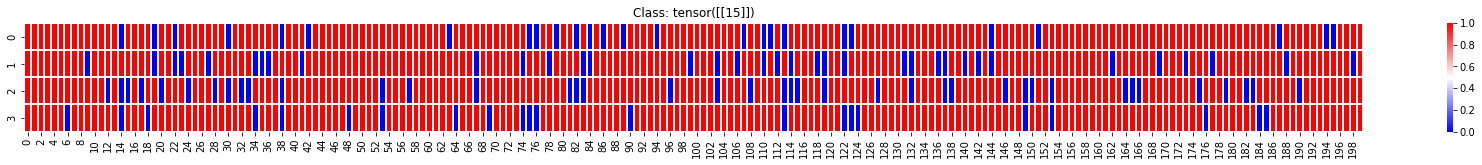

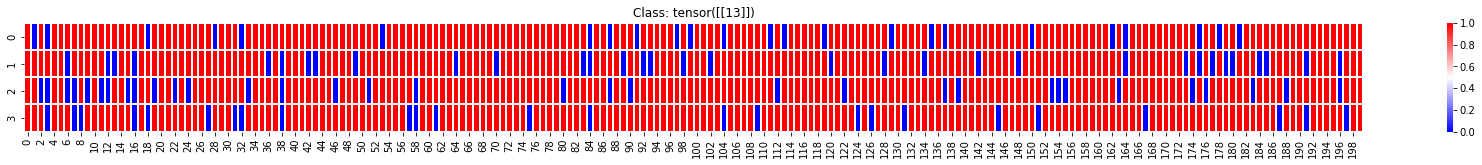

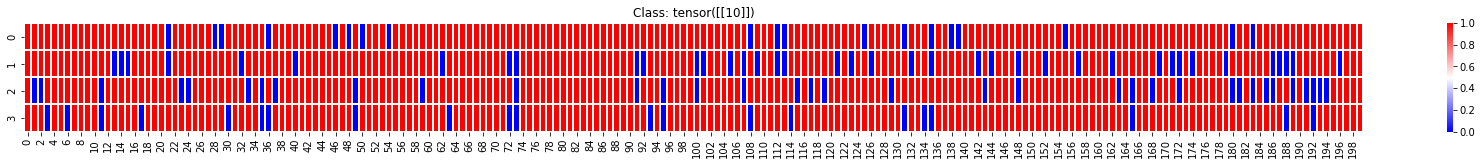

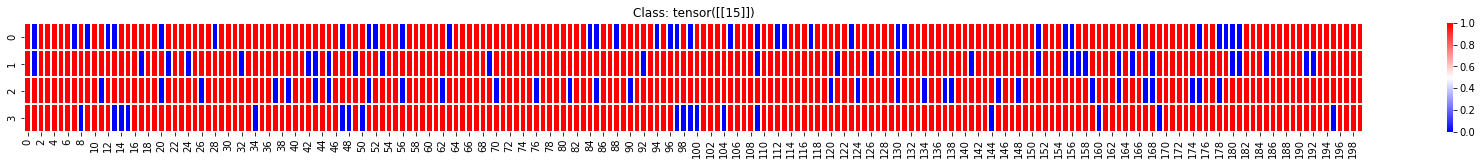

In [ ]:
sample_bs = 4 
sampled = torch.from_numpy(np.random.randint(0, len(cell_types), size=(sample_bs)))
random_classes = torch.zeros((sample_bs, len(cell_types)))
random_classes = random_classes.scatter_(1, sampled.unsqueeze(dim=1), 1).float().cuda()
sampled_images = bit_diffusion.sample(batch_size=sample_bs, classes=random_classes)
random_classes = random_classes.cpu()
sampled_images = sampled_images.cpu()
for x, c in zip(sampled_images, random_classes):
  df = pd.DataFrame(x.squeeze().numpy())
  plt.rcParams["figure.figsize"] = (30,2)
  plt.title(f"Class: {c.nonzero()}")
  sns.heatmap(df, cmap='bwr', linewidths=1)
  plt.show() 

# Generating some images to secondary evaluations


# Metrics Tasks


---


 - Define internal metrics to evaluate the quality of the produced sequences 
 -Implement a motif composition distance   
  DNA motifs represent common regulation signatures. We need to make sure the synthetic sequences are rich in these motifs. We can use gimme motifs to scan 500 different motifs on our sequences. We can compare these motifs enrichments in the real sequences and the synthetic ones (We can make this same comparison by cell type)  
 
 -Implement FDI and IS 



---

How to extract meaningfull representation from our model?
---
 -Learning with the model (Explaining predictions, motifs extractions and visualization) 



# Sampling new sequences from the model
Make sure install 
!genomepy install hg38 --annotation

In [ ]:
# This script will sample 100 different sequeces and generate the motif composition from them.



final_sequences=[]
for n_a in tqdm_notebook(range(25)): # generating 100 sequences
  sampled_images = bit_diffusion.sample(batch_size = 4)
  sampled_images = sampled_images.cpu()
  for n_b, x in enumerate(sampled_images):
    seq_final = f'>seq_test_{n_a}_{n_b}\n' +''.join([nucleotides[s] for s in np.argmax(x.reshape(4,200), axis=0)]) 
    final_sequences.append(seq_final)






# Generating Motifs plot

To generate the synthetic sequences motifs install   
  
```! pip install gimmemotifs   # install tool  ```  

```!genomepy install hg38 --annotation  #install genome  ```

 obs:This can take more than 10 minutes 


In [ ]:
# Creating the database more frequent motifs
import matplotlib.pyplot as plt


#using the file generated previously 
!gimme scan fastq_train_component.fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed




df_results_seq_guime = pd.read_csv('train_results_motifs.bed', sep='\t', skiprows=5, header=None)
df_results_seq_guime['motifs'] = df_results_seq_guime[8].apply(lambda x: x.split( 'motif_name "'    )[1].split('"')[0]   )
df_results_seq_guime_count = df_results_seq_guime.groupby('motifs').count()


plt.rcParams["figure.figsize"] = (30,2)

df_results_seq_guime_count.sort_values(0, ascending=False).head(50)[0].plot.bar()
plt.title('Top 50 MOTIFS on component 0 ')
plt.show()

In [ ]:
#Creating the synthetic sequence more frequent motifs
save_motifs_syn = open('synthetic_motifs.fasta', 'w')

save_motifs_syn.write('\n'.join(final_sequences))
save_motifs_syn.close()
!gimme scan synthetic_motifs.fasta -p  JASPAR2020_vertebrates -g hg38 > syn_results_motifs.bed
df_results_syn = pd.read_csv('syn_results_motifs.bed', sep='\t', skiprows=5, header=None)
df_results_syn['motifs'] = df_results_syn[8].apply(lambda x: x.split( 'motif_name "'    )[1].split('"')[0]   )
df_motifs_count_syn = df_results_syn.groupby('motifs').count()
plt.rcParams["figure.figsize"] = (30,2)
df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()

scanning: 100% 172/172 [00:03<00:00, 50.72 sequences/s]
